In [1]:
import os

os.chdir('c:\\Users\\inman\\Documents\\RDII\\CEE690_SoftwareEng_Spring26\\RDII')
os.getcwd()


'c:\\Users\\inman\\Documents\\RDII\\CEE690_SoftwareEng_Spring26\\RDII'

In [103]:
import pandas as pd
import matplotlib.pyplot as plt

df=pd.read_csv('data/processed/cleaned_flow_data.csv')
df.head()

df['DateTime'] = pd.to_datetime(df['DateTime'])

In [104]:
df.QC_flag.unique()

array(['OK', 'INTERPOLATED', 'MISSING', 'FLATLINE_REMOVED'], dtype=object)

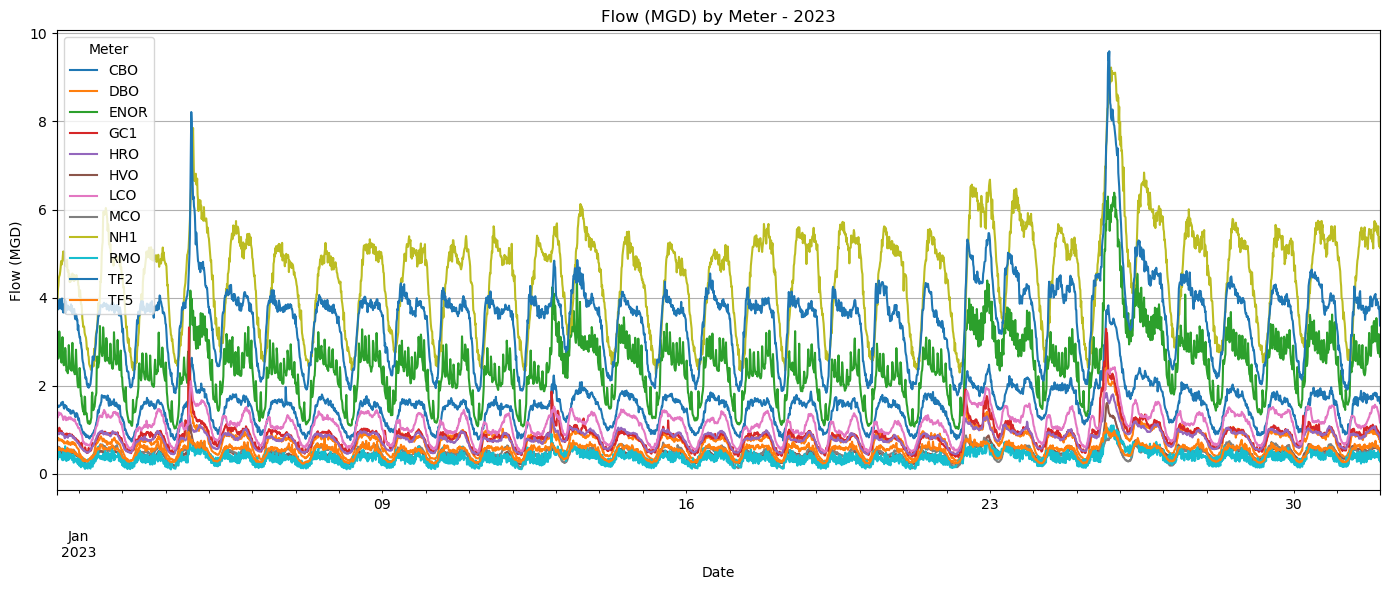

In [5]:
df_2023 = df[df['DateTime'].dt.year == 2023]
df_2023_01 = df_2023[df_2023['DateTime'].dt.month == 1]


df_pivot = df_2023_01.pivot_table(
    index='DateTime',
    columns='Meter',
    values='Flow_MGD'
)

plt.figure(figsize=(14,6))
df_pivot.plot(ax=plt.gca())

plt.title('Flow (MGD) by Meter - 2023')
plt.ylabel('Flow (MGD)')
plt.xlabel('Date')
plt.legend(title='Meter')
plt.grid(True)
plt.tight_layout()
plt.show()

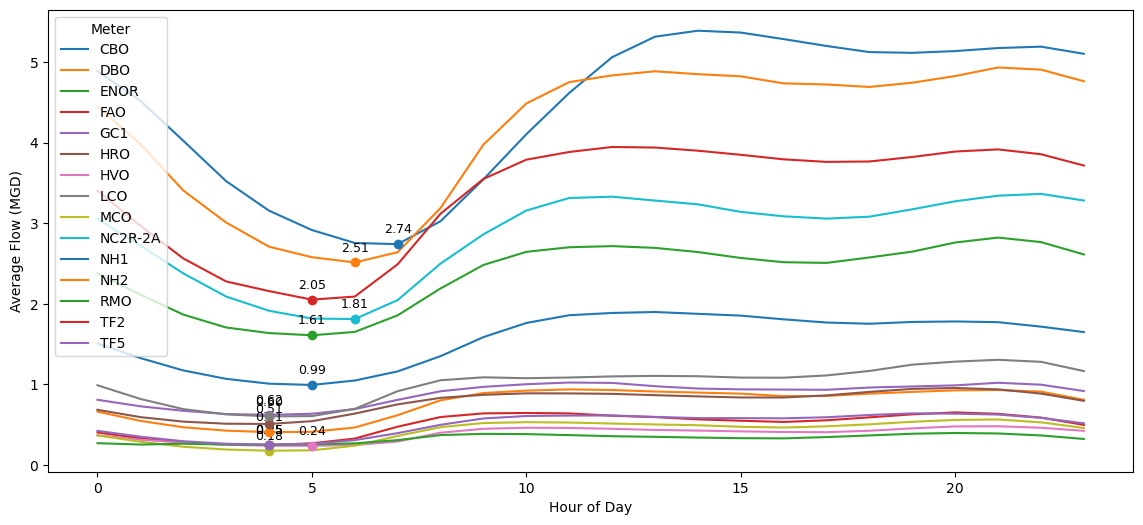

In [9]:
# plot average diurnal pattern for each meter
df['hour'] = df['DateTime'].dt.hour
diurnal_pattern = df.groupby(['hour', 'Meter'])['Flow_MGD'].mean().unstack()

plt.figure(figsize=(14,6))
ax = diurnal_pattern.plot(ax=plt.gca())

# add a point at the minimum for each line
for meter in diurnal_pattern.columns:
    min_hour = diurnal_pattern[meter].idxmin()
    min_value = diurnal_pattern[meter].min()
    
    ax.scatter(min_hour, min_value, zorder=5)  # add point
    # optional annotation
    ax.annotate(
        f'{min_value:.2f}',
        (min_hour, min_value),
        textcoords='offset points',
        xytext=(0,8),
        ha='center',
        fontsize=9
    )

plt.ylabel('Average Flow (MGD)')
plt.xlabel('Hour of Day')
plt.legend(title='Meter')
plt.show()

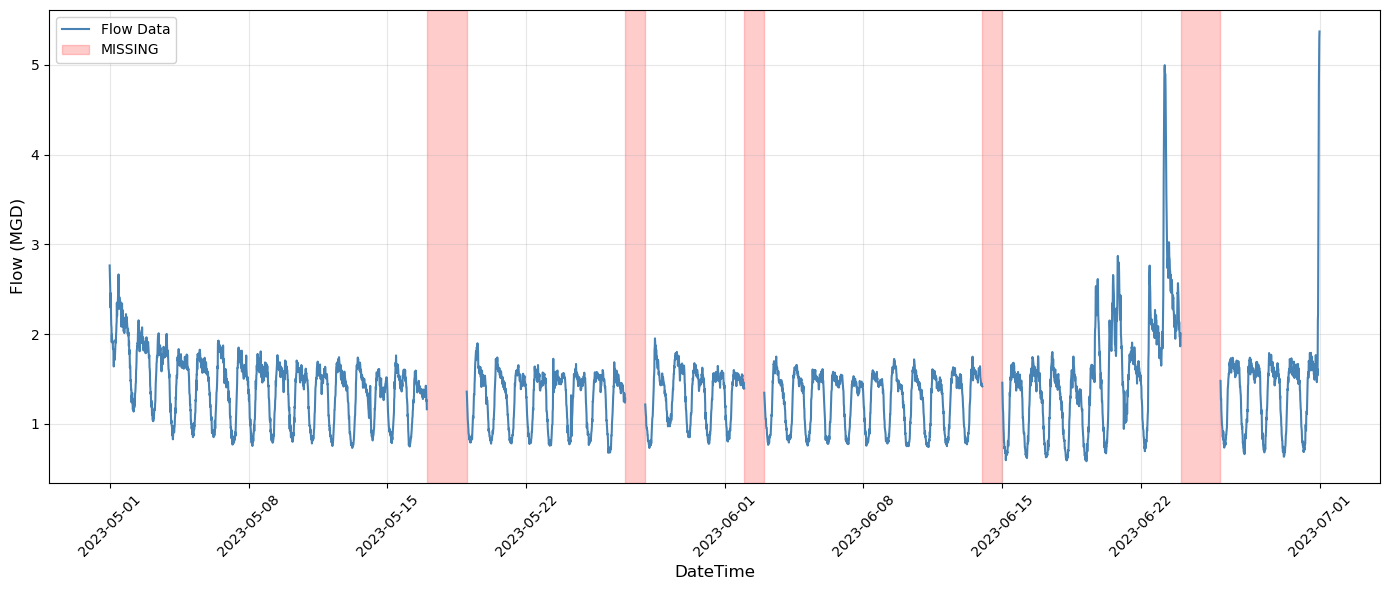

In [109]:
meter_df=df[df["Meter"]=="CBO"]
# just 2023
meter_df = meter_df[meter_df['DateTime'].dt.year == 2023]
# just month=5 and 6
meter_df = meter_df[meter_df['DateTime'].dt.month.isin([5,6])]

# Create figure
fig, ax = plt.subplots(figsize=(14,6))

# Plot main data line
ax.plot(meter_df['DateTime'], meter_df['Flow_MGD'], 
    color='steelblue', linewidth=1.5, label='Flow Data', zorder=3)

# Add shaded regions for non-OK periods
non_ok = meter_df[meter_df['QC_flag'] != 'OK'].copy()

if len(non_ok) > 0:
    # Group consecutive non-OK periods
    non_ok['group'] = (non_ok['DateTime'].diff() > pd.Timedelta('15min')).cumsum()

    qc_colors = {
        'INTERPOLATED': 'orange',
        'MISSING': 'red',
        'FLATLINE_REMOVED': 'purple',
        'NEGATIVE': 'brown'
        
    }

    for qc_flag, color in qc_colors.items():
        flag_groups = non_ok[non_ok['QC_flag'] == qc_flag].groupby('group')
        
        first_of_type = True
        for _, group in flag_groups:
            if len(group) > 0:
                # Add label only for first occurrence of each type
                label = qc_flag if first_of_type else None
                first_of_type = False
                
                ax.axvspan(
                    group['DateTime'].min(),
                    group['DateTime'].max(),
                    color=color,
                    alpha=0.2,
                    label=label,
                    zorder=1
                )

# Formatting
ax.set_xlabel('DateTime', fontsize=12)
ax.set_ylabel('Flow (MGD)', fontsize=12)
ax.legend(loc='best', framealpha=0.9)
ax.grid(True, alpha=0.3, zorder=0)
plt.xticks(rotation=45)
plt.tight_layout()

In [116]:
# src/rdii/remove_BWI.py
"""Module for calculating and removing Base Wastewater Infiltration (BWI) from flow data."""

import pandas as pd
import numpy as np

def calculate_BWI_minflow(df, fraction_min=0.85, rolling_window=30, night_start=1, night_end=7):
    """
    Calculate Base Wastewater Infiltration (BWI) minimum flow using nighttime flows.

    """
    
    df_night = df.copy()
    
    # Ensure DateTime is index
    if 'DateTime' in df_night.columns:
        df_night = df_night.set_index('DateTime')
    
    df_night['hour'] = df_night.index.hour
    
    # Filter to nighttime hours (typical minimum-use period)
    night_window = df_night[(df_night['hour'] >= night_start) & (df_night['hour'] <= night_end)]
    
    # Calculate daily minimum nighttime flow
    mnf_daily = night_window['Flow_MGD'].resample('D').min()
    
    # Remove outliers using Tukey method (IQR-based)
    Q1 = mnf_daily.quantile(0.25)
    Q3 = mnf_daily.quantile(0.75)
    IQR = Q3 - Q1
    
    # Upper bound for typical nighttime flows
    upper_bound = Q3 + (1.5 * IQR)
    mnf_daily_cleaned = mnf_daily[mnf_daily < upper_bound]
    
    # Apply rolling mean smoothing
    mnf_smoothed = mnf_daily_cleaned.rolling(
        window=rolling_window,
        center=True,
        min_periods=max(1, rolling_window // 3)  # Require at least 1/3 of window
    ).mean()
    
    # Align smoothed daily MNF to original 15-min resolution
    # Forward-fill to propagate each day's value across all its 15-min intervals
    mnf_15min = mnf_smoothed.reindex(df_night.index, method='ffill')
    
    # Apply fraction to get BWI estimate
    bwi_estimate = mnf_15min * fraction_min

    return bwi_estimate

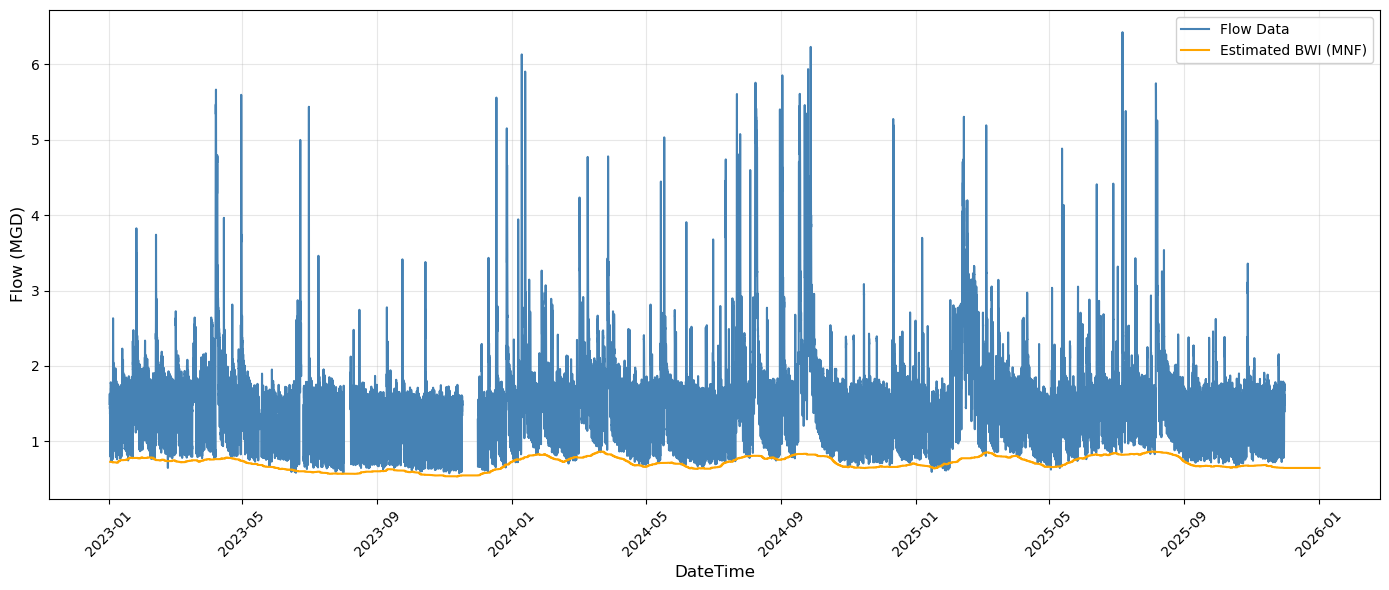

In [117]:
meter_df = df[df['Meter'] == "CBO"].copy()
meter_df['DateTime'] = pd.to_datetime(meter_df['DateTime'])
meter_df = meter_df.sort_values('DateTime')



# Calculate BWI estimate
bwi_estimate = calculate_BWI_minflow(meter_df, fraction_min=0.85)

# Create figure
fig, ax = plt.subplots(figsize=(14, 6))

# Plot main data line
ax.plot(meter_df['DateTime'], meter_df['Flow_MGD'], 
        color='steelblue', linewidth=1.5, label='Flow Data', zorder=3)

# Plot BWI estimate
ax.plot(bwi_estimate.index, bwi_estimate.values, 
        color='orange', linewidth=1.5, label='Estimated BWI (MNF)', zorder=4)

# Formatting
ax.set_xlabel('DateTime', fontsize=12)
ax.set_ylabel('Flow (MGD)', fontsize=12)
ax.legend(loc='best', framealpha=0.9)
ax.grid(True, alpha=0.3, zorder=0)
plt.xticks(rotation=45)
plt.tight_layout()


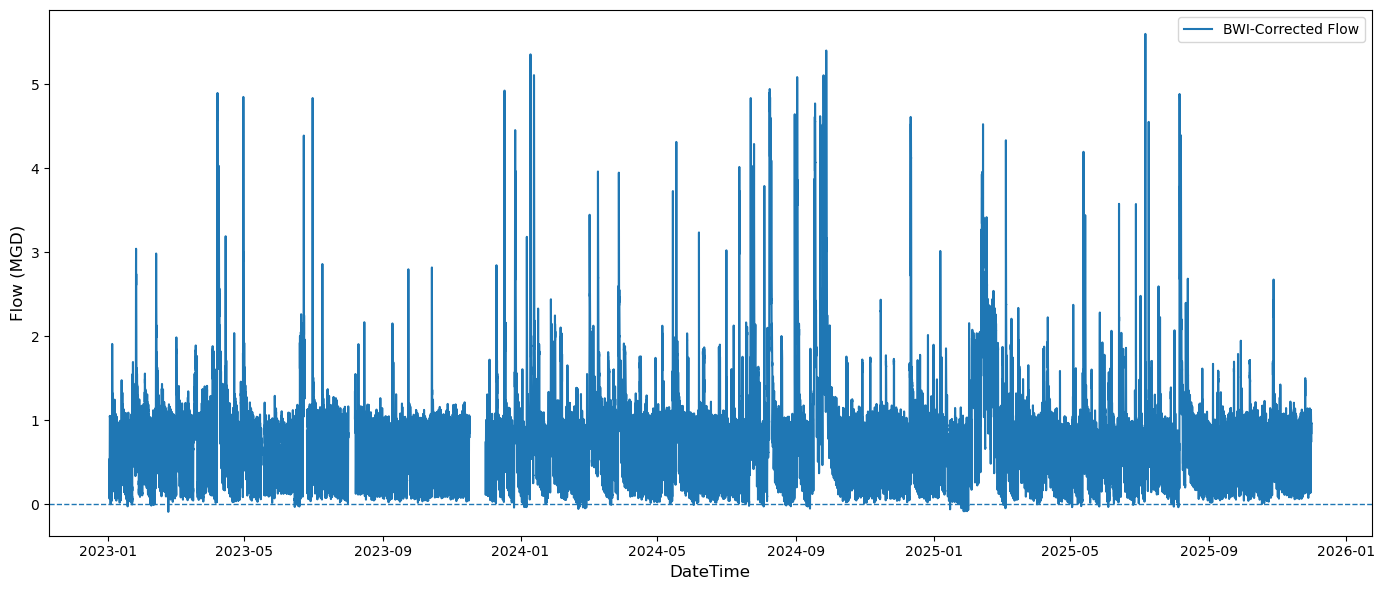

In [121]:

def remove_BWI(df, bwi_estimate):
    """
    Remove BWI estimate from original flow data.
    """
    
    df_corrected = df.copy()
    
    # Ensure DateTime is index
    if 'DateTime' in df_corrected.columns:
        df_corrected = df_corrected.set_index('DateTime')
    
    # Subtract BWI estimate from original flow
    df_corrected['Flow_MGD_BWI_Corrected'] = df_corrected['Flow_MGD'] - bwi_estimate
    
    return df_corrected.reset_index()

meter_df = df[df['Meter'] == "CBO"].copy()
meter_df['DateTime'] = pd.to_datetime(meter_df['DateTime'])
meter_df = meter_df.sort_values('DateTime') 
bwi_estimate = calculate_BWI_minflow(meter_df, fraction_min=0.85)
corrected_df = remove_BWI(meter_df, bwi_estimate)

#plot corrected flow
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(corrected_df['DateTime'],
        corrected_df['Flow_MGD_BWI_Corrected'],
        linewidth=1.5,
        label='BWI-Corrected Flow',
        zorder=3)

# horizontal zero line
ax.axhline(0, linestyle='--', linewidth=1)

ax.set_xlabel('DateTime', fontsize=12)
ax.set_ylabel('Flow (MGD)', fontsize=12)
ax.legend()
plt.tight_layout()
plt.show()



In [128]:
# MAIN ALGORITHM OUTLINE

import holidays
import pandas as pd
import numpy as np  
from prophet import Prophet
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')



def detect_wet_dry_periods(df, k=3, max_iterations=50, termination_threshold=0.05):
    """
    Iterative anomaly detection for I/I identification
    """
    
    # 1. INITIALIZE
    training_data = df[['DateTime', 'Flow_MGD_BWI_Corrected']].copy()
    training_data.rename(columns={
            'DateTime': 'ds',
            'Flow_MGD_BWI_Corrected': 'y'
        }, inplace=True)
    
    training_data = training_data.dropna()
    original_data = training_data.copy()

    us_holidays = holidays.US(years=range(
        training_data['ds'].min().year,
        training_data['ds'].max().year + 1
    ))

    holiday_df = pd.DataFrame({
        'ds': pd.to_datetime(list(us_holidays.keys())),
        'holiday': list(us_holidays.values())
    })

    # Track iterations for visualization
    iteration_history = []
    previous_forecast = None
    iteration = 0
    
    while iteration < max_iterations:
        print(f"\nIteration {iteration + 1}:")

        # 2. TRAIN BWF RECONSTRUCTION MODEL (Prophet)
        model = Prophet(
            # Trend component (piecewise linear)
            growth='linear',
            changepoint_prior_scale=0.05,
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=True,
            holidays=holiday_df
        )
        
        model.fit(training_data)
        
        # Predict on ORIGINAL data (not just training data)
        forecast = model.predict(original_data[['ds']])
        
        # 3. CALCULATE RESIDUALS (on training data only)
        train_indices = training_data.index
        train_forecast = forecast.loc[train_indices]
        residuals = training_data['y'].values - train_forecast['yhat'].values        
        
        mu = residuals.mean()
        sigma = residuals.std()

        print(f"  Residual stats: μ={mu:.4f}, σ={sigma:.4f}")

        
        # 4. ANOMALY DETECTION (k-sigma rule)
        lower_bound = mu - k * sigma
        upper_bound = mu + k * sigma
        anomalies = (residuals < lower_bound) | (residuals > upper_bound)
        n_anomalies = anomalies.sum()
        print(f"  Anomalies detected: {n_anomalies} ({100*n_anomalies/len(training_data):.1f}%)")

        # Store iteration info
        iteration_history.append({
            'iteration': iteration,
            'forecast': forecast.copy(),
            'n_points': len(training_data),
            'n_anomalies': n_anomalies,
            'mu': mu,
            'sigma': sigma,
            'bounds': (lower_bound, upper_bound)
        })

         # 5. CHECK TERMINATION CONDITIONS
        should_terminate, reason = check_termination(
            residuals, forecast, previous_forecast, threshold
        )
        
        if should_terminate:
            print(f"\nTerminating: {reason}")
            break
        
        if n_anomalies == 0:
            print("\nTerminating: No more anomalies detected")
            break
            
        # 6. REMOVE ANOMALIES FOR NEXT ITERATION
        training_data = training_data.loc[~anomalies]
        previous_forecast = forecast
        iteration += 1
    
    print(f"\nCompleted after {iteration + 1} iterations")
    
    # 7. FINAL ANOMALY CLASSIFICATION on all original data
    final_forecast = iteration_history[-1]['forecast']
    final_residuals = original_data['y'].values - final_forecast['yhat'].values
    final_mu = iteration_history[-1]['mu']
    final_sigma = iteration_history[-1]['sigma']
    final_lower = final_mu - k * final_sigma
    final_upper = final_mu + k * final_sigma
    
    wet_labels = (final_residuals < final_lower) | (final_residuals > final_upper)
    
    # 8. ISOLATED POINT REMOVAL
    wet_labels_cleaned = remove_isolated_points(wet_labels, window_size=12)
    
    print(f"\nFinal classification:")
    print(f"  Wet periods: {wet_labels_cleaned.sum()} points ({100*wet_labels_cleaned.sum()/len(wet_labels_cleaned):.1f}%)")
    print(f"  Dry periods: {(~wet_labels_cleaned).sum()} points ({100*(~wet_labels_cleaned).sum()/len(wet_labels_cleaned):.1f}%)")
    
    # 9. CALCULATE I/I FLOW
    ii_flow = original_data['y'].values - final_forecast['yhat'].values
    ii_flow[~wet_labels_cleaned] = 0  # No I/I during dry periods
    
    return {
        'wet_dry_labels': wet_labels_cleaned,
        'ii_flow': ii_flow,
        'forecast': final_forecast,
        'original_data': original_data,
        'iteration_history': iteration_history,
        'final_bounds': (final_lower, final_upper)
    }



def check_termination(residuals, current_forecast, previous_forecast, threshold):
    """
    Check if any termination condition is met

    """
    
    # Condition 1: Normality test (Anderson-Darling)
    result = stats.anderson(residuals, dist='norm')
    # If statistic < critical value, data is normal
    if result.statistic < result.critical_values[2]:  # 5% significance
        return True, "Residuals pass normality test"
    
    # Condition 2: Maximum residual threshold
    max_abs_residual = np.abs(residuals).max()
    if max_abs_residual < threshold:
        return True, f"Max residual ({max_abs_residual:.4f}) below threshold ({threshold})"
    
    # Condition 3: High correlation between successive forecasts
    if previous_forecast is not None:
        correlation, _ = pearsonr(
            current_forecast['yhat'].values,
            previous_forecast['yhat'].values
        )
        if correlation > 0.999:
            return True, f"High correlation ({correlation:.6f}) between successive forecasts"
    
    return False, None


def remove_isolated_points(labels, window_size=12):
    """
    Majority voting with sliding window to remove isolated points

    """
    labels = np.array(labels)
    cleaned_labels = labels.copy()
    
    half_window = window_size // 2
    
    for i in range(len(labels)):
        start = max(0, i - half_window)
        end = min(len(labels), i + half_window + 1)
        window = labels[start:end]
        
        # Majority vote
        if window.sum() > len(window) / 2:
            cleaned_labels[i] = True  # Wet
        else:
            cleaned_labels[i] = False  # Dry
    
    return cleaned_labels


def plot_iterations(results, show_every_n=5):
    """
    Plot the BWF reconstruction for each iteration
    """
    
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    original = results['original_data']
    history = results['iteration_history']
    
    # Top plot: All iterations overlaid
    ax1 = axes[0]
    
    # Plot original data
    ax1.plot(original['ds'], original['y'], 'o', 
             color='gray', alpha=0.3, markersize=2, label='Measured Flow')
    
    # Plot each iteration
    n_iterations = len(history)
    colors = plt.cm.viridis(np.linspace(0, 1, n_iterations))
    
    for i, iter_info in enumerate(history):
        if i % show_every_n == 0 or i == n_iterations - 1:
            forecast = iter_info['forecast']
            label = f"Iteration {iter_info['iteration'] + 1}"
            if i == n_iterations - 1:
                label += " (Final)"
                ax1.plot(forecast['ds'], forecast['yhat'], 
                        linewidth=2.5, color='red', label=label, zorder=10)
            else:
                ax1.plot(forecast['ds'], forecast['yhat'], 
                        linewidth=1, alpha=0.6, color=colors[i], label=label)
    
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Flow (MGD)', fontsize=12)
    ax1.set_title('BWF Reconstruction Across Iterations', fontsize=14, fontweight='bold')
    ax1.legend(loc='upper right', fontsize=9)
    ax1.grid(True, alpha=0.3)
    
    # Bottom plot: Final result with wet/dry classification
    ax2 = axes[1]
    
    wet_labels = results['wet_dry_labels']
    final_forecast = results['forecast']
    bounds = results['final_bounds']
    
    # Plot dry periods
    dry_mask = ~wet_labels
    ax2.plot(original['ds'][dry_mask], original['y'][dry_mask], 'o',
             color='blue', alpha=0.5, markersize=3, label='Dry Weather Flow')
    
    # Plot wet periods
    wet_mask = wet_labels
    ax2.plot(original['ds'][wet_mask], original['y'][wet_mask], 'o',
             color='red', alpha=0.5, markersize=3, label='Wet Weather (I/I)')
    
    # Plot final BWF
    ax2.plot(final_forecast['ds'], final_forecast['yhat'],
             linewidth=2, color='darkblue', label='Base Weather Flow', zorder=5)
    
    # Plot confidence bounds
    ax2.fill_between(final_forecast['ds'],
                     final_forecast['yhat'] + bounds[0],
                     final_forecast['yhat'] + bounds[1],
                     alpha=0.2, color='blue', label=f'{k}σ Bounds')
    
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Flow (MGD)', fontsize=12)
    ax2.set_title('Final Wet/Dry Classification', fontsize=14, fontweight='bold')
    ax2.legend(loc='upper right', fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('ii_detection_iterations.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Additional plot: Iteration statistics
    fig2, axes2 = plt.subplots(2, 2, figsize=(14, 10))
    
    iterations = [h['iteration'] + 1 for h in history]
    n_points = [h['n_points'] for h in history]
    n_anomalies = [h['n_anomalies'] for h in history]
    sigmas = [h['sigma'] for h in history]
    mus = [h['mu'] for h in history]
    
    # Training points
    axes2[0, 0].plot(iterations, n_points, 'o-', linewidth=2, markersize=8)
    axes2[0, 0].set_xlabel('Iteration')
    axes2[0, 0].set_ylabel('Training Points Remaining')
    axes2[0, 0].set_title('Training Data Reduction')
    axes2[0, 0].grid(True, alpha=0.3)
    
    # Anomalies per iteration
    axes2[0, 1].bar(iterations, n_anomalies, color='coral', alpha=0.7)
    axes2[0, 1].set_xlabel('Iteration')
    axes2[0, 1].set_ylabel('Anomalies Detected')
    axes2[0, 1].set_title('Anomalies Removed Per Iteration')
    axes2[0, 1].grid(True, alpha=0.3, axis='y')
    
    # Standard deviation
    axes2[1, 0].plot(iterations, sigmas, 's-', linewidth=2, markersize=8, color='green')
    axes2[1, 0].set_xlabel('Iteration')
    axes2[1, 0].set_ylabel('Standard Deviation (σ)')
    axes2[1, 0].set_title('Residual Standard Deviation')
    axes2[1, 0].grid(True, alpha=0.3)
    
    # Mean
    axes2[1, 1].plot(iterations, mus, 'd-', linewidth=2, markersize=8, color='purple')
    axes2[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    axes2[1, 1].set_xlabel('Iteration')
    axes2[1, 1].set_ylabel('Mean Residual (μ)')
    axes2[1, 1].set_title('Residual Mean Convergence')
    axes2[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('ii_detection_statistics.png', dpi=300, bbox_inches='tight')
    plt.show()

In [129]:
# Run the detection
results = detect_wet_dry_periods(
    corrected_df,
    k=3,
    max_iterations=3,
    threshold=0.5
)

# Visualize
plot_iterations(results, show_every_n=3)

# Access results
wet_periods = results['wet_dry_labels']
ii_flow = results['ii_flow']

# Add to dataframe
df['is_wet'] = wet_periods
df['ii_flow'] = ii_flow
df['bwf'] = results['forecast']['yhat'].values

TypeError: detect_wet_dry_periods() got an unexpected keyword argument 'threshold'

13:05:11 - cmdstanpy - INFO - Chain [1] start processing
13:06:10 - cmdstanpy - INFO - Chain [1] done processing


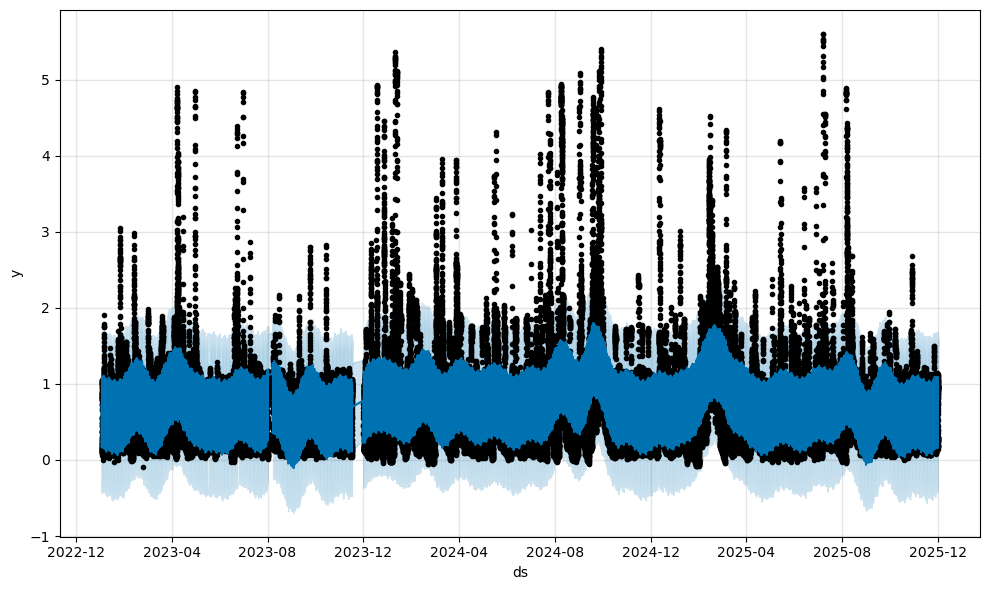

In [ ]:
from prophet import Prophet
import holidays

training_data = corrected_df[['DateTime', 'Flow_MGD_BWI_Corrected']].copy()
training_data.rename(columns={
    'DateTime': 'ds',
    'Flow_MGD_BWI_Corrected': 'y'
}, inplace=True)

training_data = training_data.dropna()

us_holidays = holidays.US()

holiday_df = pd.DataFrame({
    'ds': pd.to_datetime(list(us_holidays.keys())),
    'holiday': list(us_holidays.values())
})

# 2. TRAIN BWF RECONSTRUCTION MODEL (Prophet)
model = Prophet(
    # Trend component (piecewise linear)
    growth='linear',
    changepoint_prior_scale=0.05,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    holidays=holiday_df
)

model.fit(training_data)
forecast = model.predict(training_data)

fig1 = model.plot(forecast)
plt.show()

#black dots → observed data

#blue line → model fit

#light band → uncertainty